In [1]:
#Import necessary packages
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from gensim.models import KeyedVectors
import operator 
import pandas as pd
from tqdm import tqdm
import re
import gensim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
tqdm.pandas()

Using TensorFlow backend.


In [2]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 95000 # how many unique words to use (i.e num rows in embedding vector)
max_seq_len = 50
EMBEDDING_MATRIX_FILE = 'embedding_matrix.npy'

In [3]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

#Read the dataframes
def get_word_index(train):
    train_df = train
    ## fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    return tokenizer.word_index

def load_and_prec(train,test):
    train_df = train
    test_df = test
    print("Train shape : ",train_df.shape)
    print("Test shape : ",test_df.shape)
    
    ## fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values
    
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=max_seq_len)
    test_X = pad_sequences(test_X, maxlen=max_seq_len)

    ## Get the target values
    train_y = train_df['target'].values
    #shuffling the data
    np.random.seed(2018)
    trn_idx = np.random.permutation(len(train_X))

    train_X = train_X[trn_idx]
    train_y = train_y[trn_idx]
    
    return train_X, test_X, train_y

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

In [4]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling',"apologised" : "apologize"
                ,"demisexual" : "sexual","Whate" : "What","learnt" : "learn", 'counselling': 'counseling', 'theatre': 'theater', 
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization',"sexualy" : "sexually","Whydoes" : "why does", 
                'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 
                'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 
                'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ether', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization',"honour" : "honor" , "honours" : "honor","licence" : "license" ,
                "cryptocurrency" : "money","cryptocurrencies" : "money","programme": "program","B.E.":"education",
                      "Redmi" : "Mobile","mtech":"education","Btech" : "education","btech" : "education","bitcoin" : "money",
                "programr" : "programmer","programrs" : "programmer","realise" : "realize" , "behaviour" : "behavior", "blockchain" : "technology"
               ,"Whatis" : "What is","bcom" : "education","favour":"favor","cheque":"Check"}
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                       "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", 
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" , 
                       "clg" : "college","Demonetization" : "demonetization","what's" : "what is","don't" : "do not",
                       "What's" : "What is","Don't" : "Do not","a" : "A" , "of" : "Of","to" : "To","and" : "And","that's":"that is","That's" : "That is"}
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [6]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '?' : '',',':' ','"':' ','(':' '}
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f'{p}')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [7]:
def clean_text(x):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

In [8]:
def load_GoogleNews_index():
    EMBEDDING_FILE = '../input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
    embedding_index = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
    return embedding_index

def load_embedding_matrix(word_index,embeddings_index):
    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index)) + 1
    embedding_matrix = np.zeros((nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features or word not in embeddings_index:
            continue
        embedding_vector = embeddings_index.get_vector(word)            
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

In [9]:
embedding_index = load_GoogleNews_index()

In [10]:
import nltk
from nltk.tokenize import word_tokenize

In [11]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

train["question_text"] = train["question_text"].apply(lambda x: clean_contractions(x, contraction_mapping))
train["question_text"] = train["question_text"].apply(lambda x: clean_special_chars(x, punct, punct_mapping))
train['question_text'] = train['question_text'].apply(lambda x : clean_text(x))
train["question_text"] = train["question_text"].apply(lambda x: clean_numbers(x))
train["question_text"] = train["question_text"].apply(lambda x: correct_spelling(x, mispell_dict))
#train["question_text"] = train["question_text"].apply(lambda x: ' '.join([w for w in word_tokenize(x) if w not in ['a','to','of','and']]))

test["question_text"] = test["question_text"].apply(lambda x: clean_contractions(x, contraction_mapping))
#test["question_text"] = test["question_text"].apply(lambda x: ' '.join([w for w in word_tokenize(x) if w not in ['a','to','of','and']]))
test["question_text"] = test["question_text"].apply(lambda x: clean_special_chars(x, punct, punct_mapping))
test['question_text'] = test['question_text'].apply(lambda x : clean_text(x))
test["question_text"] = test["question_text"].apply(lambda x: clean_numbers(x))
test["question_text"] = test["question_text"].apply(lambda x: correct_spelling(x, mispell_dict))

In [12]:
sentences = train["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)

100%|██████████| 1306122/1306122 [00:04<00:00, 265675.84it/s]


In [13]:
oov = check_coverage(vocab,embedding_index)

100%|██████████| 236856/236856 [00:00<00:00, 296801.35it/s]


Found embeddings for 61.84% of vocab
Found embeddings for  99.09% of all text


In [14]:
word_index = get_word_index(train)

In [15]:
embedding_matrix = load_embedding_matrix(word_index,embedding_index)
np.shape(embedding_matrix)

(95001, 300)

In [16]:
train_X, test_X, train_y  = load_and_prec(train,test)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


In [17]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
from keras.layers import Embedding,Input
from keras.layers import MaxPool1D , Dense , Dropout , GlobalMaxPooling2D , Concatenate , CuDNNGRU , Dropout,Lambda,multiply
from keras.layers import Convolution1D , CuDNNLSTM , Bidirectional , Flatten , TimeDistributed , Reshape , Activation,RepeatVector,Permute
from keras.models import Model
import keras
from keras.regularizers import L1L2 , l2
from keras import optimizers

filter_sizes = [5,4,3,2,1]
num_filters = 32
weight_decay = 1e-4

embedding_layer = Embedding(max_features + 1,
                            embed_size,
                            weights = [embedding_matrix],
                            trainable=False, name = 'Embedding')

sequence_input = Input(shape=(max_seq_len,),name='Seq_Input1')
embedded_sequences = embedding_layer(sequence_input)

#embedded_sequences = Reshape((max_seq_len, embed_size, 1))(embedded_sequences)

#Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                    # kernel_initializer='he_normal', activation='elu')(x)

pool_list = []
for i in range(len(filter_sizes)):
    conv = Convolution1D(nb_filter=36,
                         filter_length=filter_sizes[i],
                         border_mode='valid',
                         activation='relu',
                         subsample_length=1)(embedded_sequences)
    pool = MaxPool1D(pool_length=max_seq_len - filter_sizes[i]+1)(conv)
    pool_list.append(pool)

maxpool_pool1 = []
conv1 = Concatenate(axis=1)(pool_list)
for i in range(len(filter_sizes)):
    conv1 = Convolution1D(nb_filter=36,
                         filter_length=filter_sizes[i],
                         border_mode='same',
                         activation='relu',
                         subsample_length=1)(conv1)
    conv1 = MaxPool1D(pool_length=max_seq_len -  filter_sizes[i]+1,padding='same')(conv1)
    #conv1 = Flatten()(conv1)
    #maxpool_pool1.append(conv1)

    
l_lstm = Bidirectional(CuDNNLSTM(150,return_sequences= True),name='LSTM')(conv1)

attention = TimeDistributed(Dense(1, activation='tanh'))(l_lstm)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(300)(attention)
attention = Permute([2,1])(attention)

#sent_representation = merge([LSTM_layer, attention], mode='mul')
sent_representation = multiply([l_lstm, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-1))(sent_representation)

#probabilities = TimeDistributed(Dense(1, activation='sigmoid'))(sent_representation)

preds = Dense(1, activation='sigmoid',name='Output')(sent_representation)

adam = optimizers.Adam(lr=0.003)
model = Model(inputs = sequence_input,outputs = preds)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=[f1])
print(model.summary())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=36, kernel_size=5, strides=1, padding="valid")`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=46)`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=36, kernel_size=4, strides=1, padding="valid")`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=47)`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=36, kernel_size=3, strides=1, padding="valid")`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Seq_Input1 (InputLayer)         (None, 50)           0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 50, 300)      28500300    Seq_Input1[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 46, 36)       54036       Embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 47, 36)       43236       Embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_3 (

In [19]:
from sklearn.model_selection import train_test_split
train_X_, val_X_ , train_Y_ , val_Y_ = train_test_split(train_X,train_y, test_size=0.33, random_state=42)

In [20]:
#define callbacks
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [21]:
#fit the model
model.fit(train_X_, train_Y_, batch_size=512, epochs=5, verbose=1, shuffle=True ,validation_data= (val_X_,val_Y_), callbacks=callbacks_list)#, class_weight= class_weight )

Train on 875101 samples, validate on 431021 samples
Epoch 1/5
875101/875101 [==============================] - 144s 165us/step - loss: 0.1181 - f1: 0.5473 - val_loss: 0.1079 - val_f1: 0.6166
Epoch 2/5
875101/875101 [==============================] - 141s 161us/step - loss: 0.1031 - f1: 0.6297 - val_loss: 0.1101 - val_f1: 0.5604
Epoch 3/5
875101/875101 [==============================] - 142s 163us/step - loss: 0.0958 - f1: 0.6599 - val_loss: 0.1092 - val_f1: 0.6272
Epoch 4/5
632832/875101 [====================>.........] - ETA: 35s - loss: 0.0868 - f1: 0.6982

In [22]:
predicted_Y = model.predict(test_X , batch_size= 500 , verbose=1)

375806/375806 [==============================] - 14s 38us/step


In [23]:
predicted_Y = predicted_Y > 0.33

In [24]:
pred_test_y = predicted_Y.astype(int)
out_df = pd.DataFrame({"qid":test["qid"].values})
out_df['prediction'] = pred_test_y
out_df.to_csv("submission.csv", index=False)

In [25]:
out_df[out_df.prediction==1].shape

(25805, 2)

In [26]:
merged = pd.merge(test,out_df,on=[test.qid, out_df.qid])#out_df[out_df.qid == '93915191a313a164eceb']

In [27]:
merged[merged.qid_x == 'fe91a6259f58f7adc9d4']

,key_0,key_1,qid_x,question_text,qid_y,prediction
373631,fe91a6259f58f7adc9d4,fe91a6259f58f7adc9d4,fe91a6259f58f7adc9d4,Have you ever used the expression that s gay ...,fe91a6259f58f7adc9d4,0


In [28]:
merged[merged.prediction == 1]

,key_0,key_1,qid_x,question_text,qid_y,prediction
0,0000163e3ea7c7a74cd7,0000163e3ea7c7a74cd7,0000163e3ea7c7a74cd7,Why do so many women become so rude And arroga...,0000163e3ea7c7a74cd7,1
17,00025f4a23df8d58e6ff,00025f4a23df8d58e6ff,00025f4a23df8d58e6ff,Can we eat human poop,00025f4a23df8d58e6ff,1
21,000383e4ebd22f6ede04,000383e4ebd22f6ede04,000383e4ebd22f6ede04,Why do so many people on this damn site not ac...,000383e4ebd22f6ede04,1
27,00046c9db89b3d758708,00046c9db89b3d758708,00046c9db89b3d758708,Let s say that hypothetically the alt right ni...,00046c9db89b3d758708,1
37,00063c300eb37ecf44de,00063c300eb37ecf44de,00063c300eb37ecf44de,Why do most people in general feel they are so...,00063c300eb37ecf44de,1
42,00077e9f6f1069806a96,00077e9f6f1069806a96,00077e9f6f1069806a96,Why most Telugu And Marathi Muslims speak Urdu...,00077e9f6f1069806a96,1
58,000b6e98704938bc4d63,000b6e98704938bc4d63,000b6e98704938bc4d63,Why do Bengali And Kolkata people dominate Hin...,000b6e98704938bc4d63,1
93,00119f4b87fa5c1d2b00,00119f4b87fa5c1d2b00,00119f4b87fa5c1d2b00,Why do Indian girls look for only NRI boys for...,00119f4b87fa5c1d2b00,1
99,00128617c44fbc12064e,00128617c44fbc12064e,00128617c44fbc12064e,Shouldn t we blame those who knew how bad Trum...,00128617c44fbc12064e,1
105,001430505ed525e0e482,001430505ed525e0e482,001430505ed525e0e482,Why does the media let Saudi Arabia get away w...,001430505ed525e0e482,1


In [29]:

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

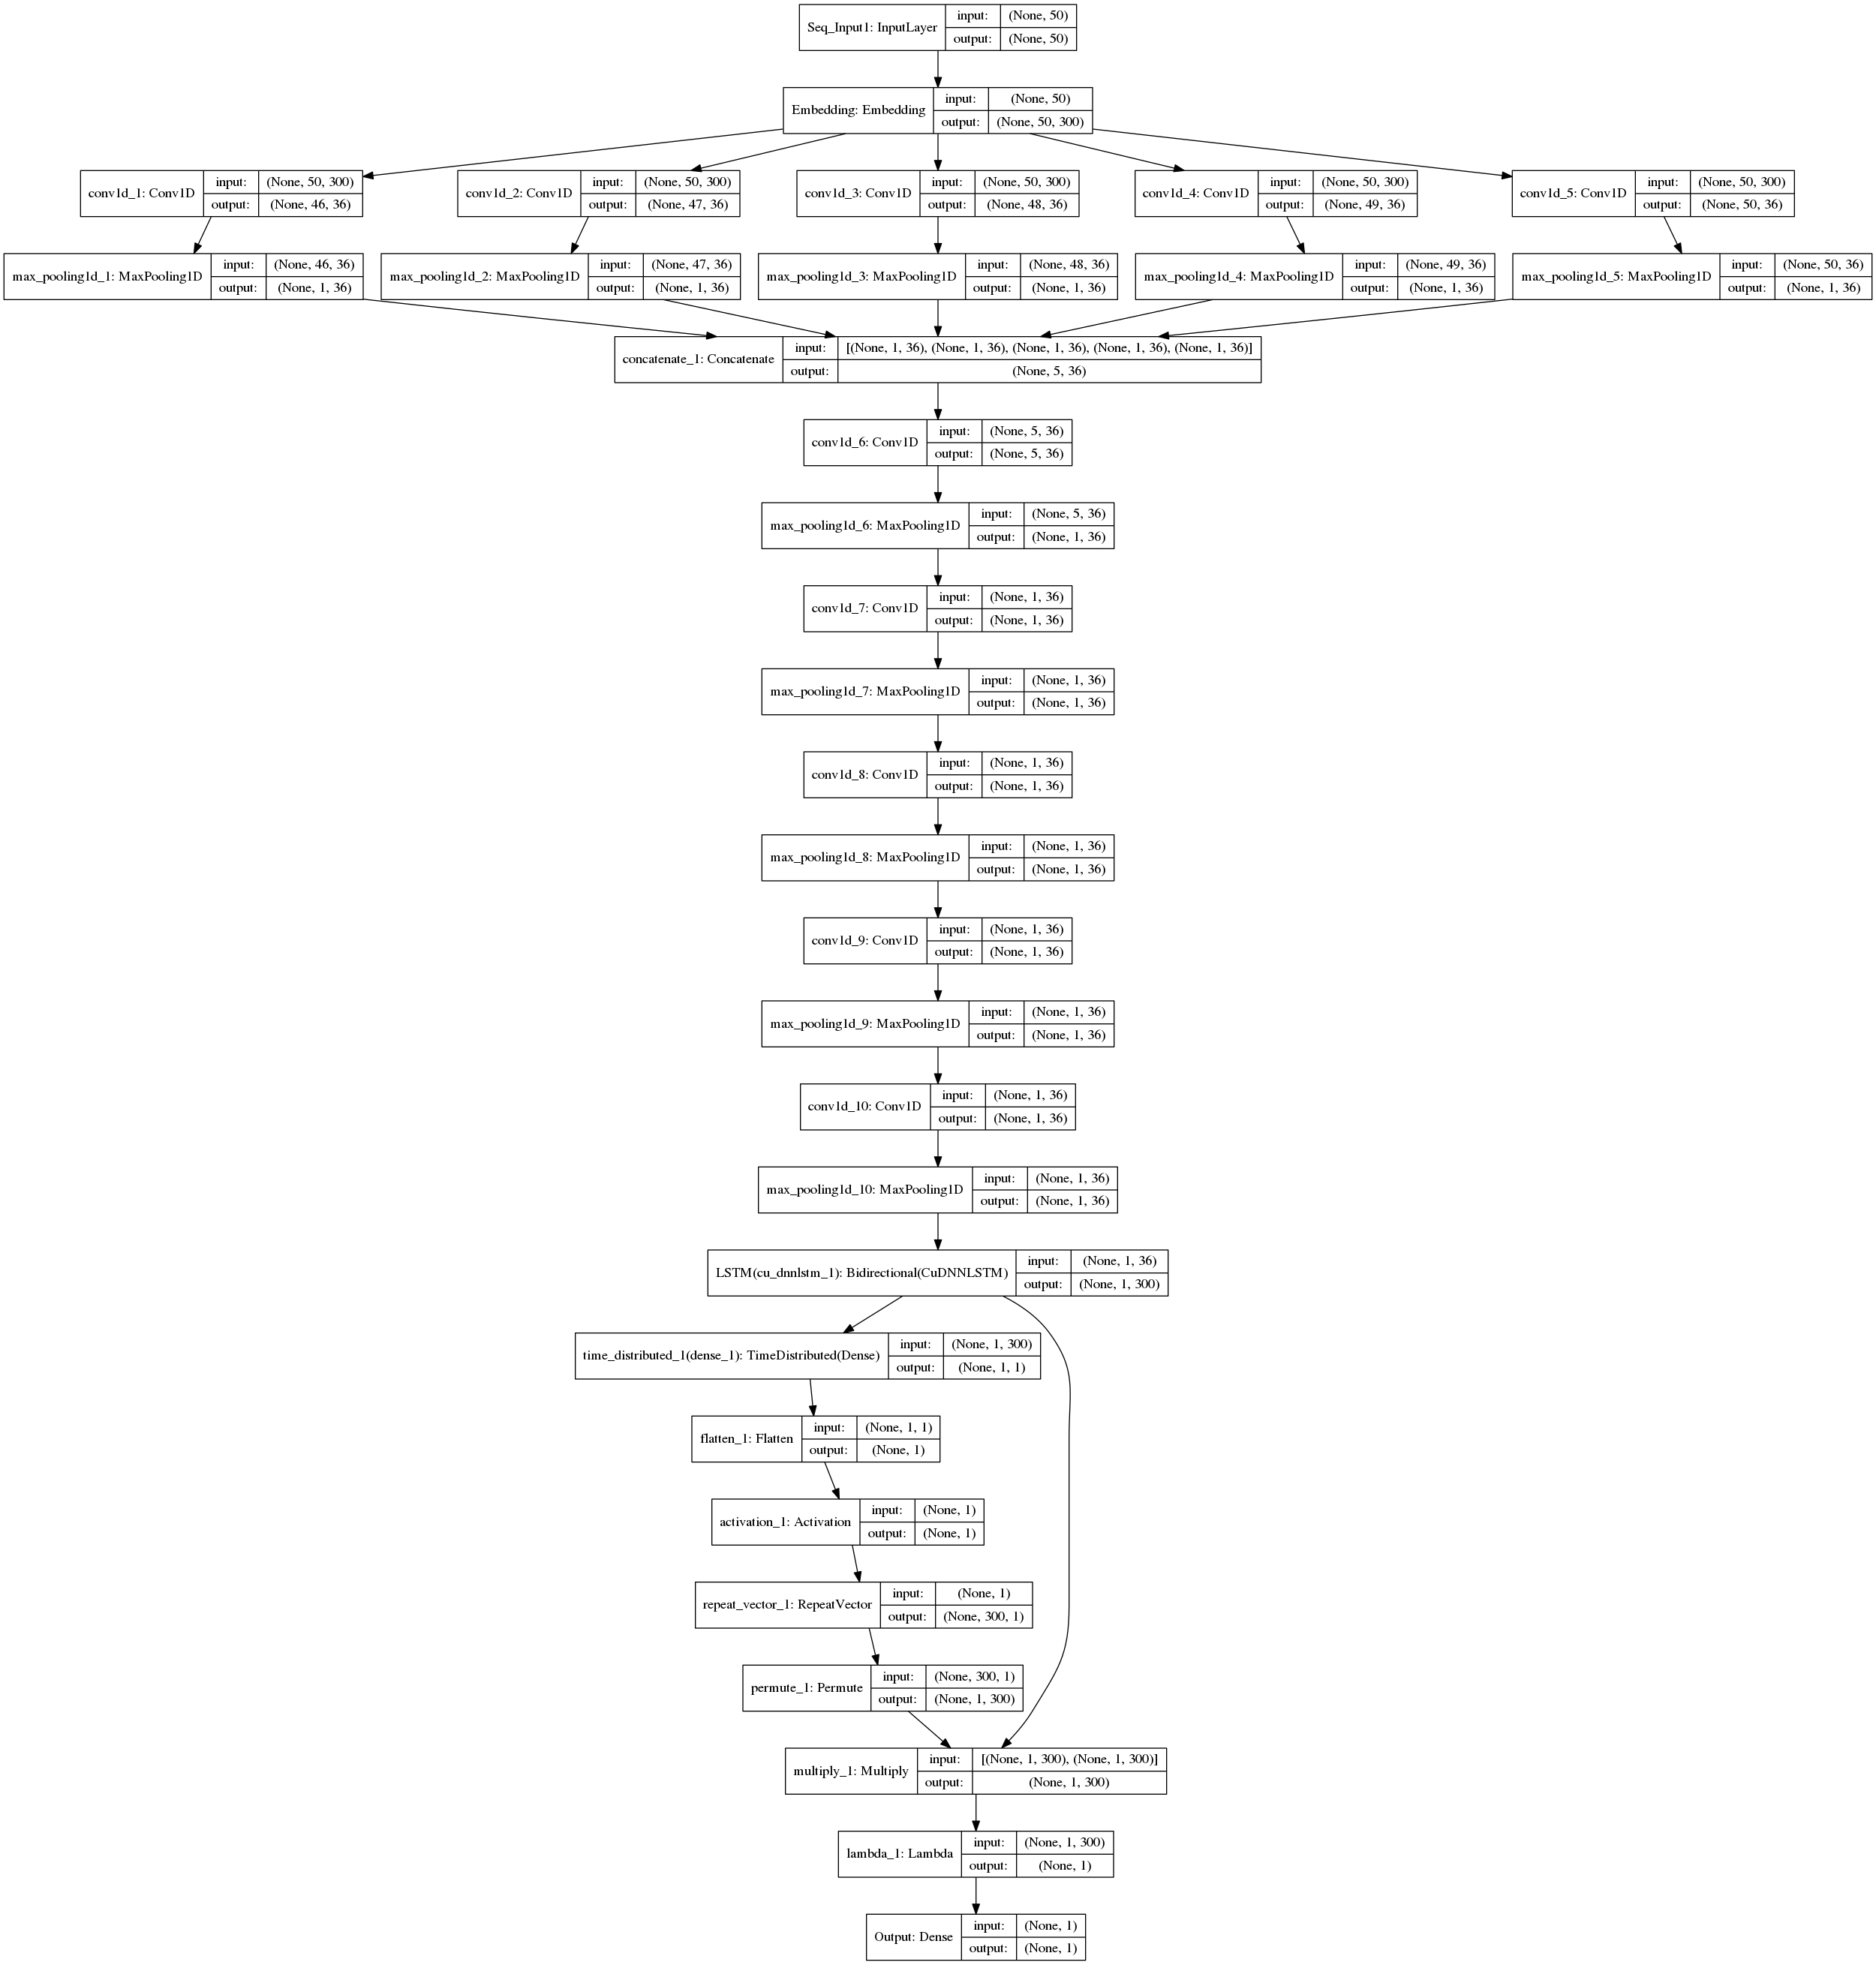

In [30]:
from IPython.display import Image
Image(filename='model_plot.png') 